In [3]:
!pip install pystan #最初だけ実行(2回目以降は不要)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import stan
import arviz
import nest_asyncio
nest_asyncio.apply()

# SIRモデルのパラメータ推定

## 擬似データの作成

In [6]:
#SIRモデル (擬似データ生成用)
def SIR_model(S,I,R,beta,gamma):
  N = S + I + R
  dSdt = - (beta/N)*S*I
  dIdt = (beta/N)*S*I - gamma*I
  dRdt = gamma*I
  return (dSdt,dIdt,dRdt)

def solve_SIR_model(S0,I0,R0,beta,gamma,dt,t_end,sampling_span):
  #初期化
  t = 0
  S = S0
  I = I0
  R = R0
  t_list = [0]
  S_list = [S]
  I_list = [I]
  R_list = [R]
  #数値積分
  for i in range(int(t_end/dt)):
    t = dt*(i+1)
    dSdt, dIdt, dRdt = SIR_model(S,I,R,beta,gamma)
    S += dSdt*dt
    I += dIdt*dt
    R += dRdt*dt
    if i%sampling_span==0:
      t_list.append(t)
      S_list.append(S)
      I_list.append(I)
      R_list.append(R)
  return(t_list,S_list,I_list,R_list)

In [7]:
#微分方程式を解くための設定
S0 = 1000
I0 = 1
R0 = 0
N = S0 + I0 + R0
dt = 0.05
t_end = 20
sampling_span = int(1/dt) #データは1/dt時点ごとにサンプリング(dt=0.1なら10ステップに1回サンプリング)

In [20]:
#正解パラメータ
beta = 2
gamma = 1


400 21 20


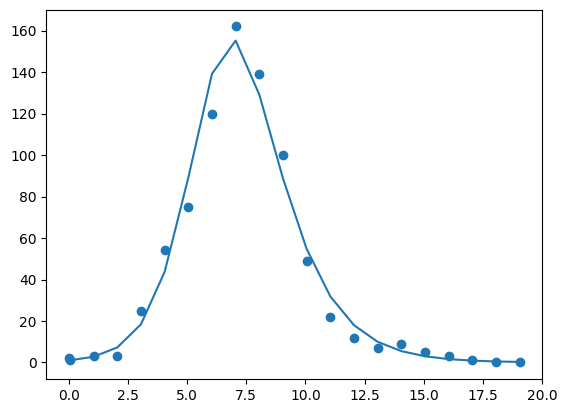

In [21]:
#擬似データ生成
t, s, i, r = solve_SIR_model(S0,I0,R0,beta,gamma,dt,t_end,sampling_span)
I = []
for j in range(len(i)):
  i_rand = np.random.poisson(i[j]) #ポアソン分布を仮定
  I.append(i_rand)
Nt_all = int(t_end/dt)
Nt_sampled = len(t)
sampling_span = int(1/dt)
print(Nt_all, Nt_sampled, sampling_span)

#擬似データの可視化
plt.plot(t,i)
plt.scatter(t,I)
plt.show()

## パラメータ推定

In [22]:
#Stanコード
stan_model = """
functions {
  array [] real solve_SIR_model(real S0, real I0, real R0, real beta, real gamma, real dt, int Nt_all, int Nt_sampled, int sample_span){

    // declaration
    array [Nt_sampled] real y;
    real t;
    real S;
    real I;
    real R;
    int j;

    // initialization
    t = 0;
    S = S0;
    I = I0;
    R = R0;
    j = 1;
    y[j] = I;

    for(i in 1:Nt_all){
      t = t + dt;
      S = S + (-(beta/(S+R+I))*S*I)*dt;
      I = I + ((beta/(S+R+I))*S*I - gamma*I)*dt;
      R = R + (gamma*I)*dt;
      if (fmod(i,sample_span)==0){
        j = j + 1;
        y[j] = I;
      }
    }
  return y;
  }
}

data {
  real S0;
  real I0;
  real R0;
  real dt;
  int Nt_all;
  int Nt_sampled;
  int sample_span;
  array [Nt_sampled] int I_obs;
}

parameters{
  real <lower=0> beta;
  real <lower=0> gamma;
}

model {
  array [Nt_sampled] real y;
  //prior
  beta ~ normal(0,10);
  gamma ~ normal(0,5);
  //likelihood
  y = solve_SIR_model(S0, I0, R0, beta, gamma, dt, Nt_all, Nt_sampled, sample_span);
  for(j in 1:Nt_sampled){
    I_obs[j] ~ poisson(y[j]+1);
  }
}

generated quantities {
  array[Nt_sampled] int I_sim;
  array[Nt_sampled] real i_sim;
  i_sim = solve_SIR_model(S0, I0, R0, beta, gamma, dt, Nt_all, Nt_sampled, sample_span);
  for(i in 1:Nt_sampled){
    I_sim[i] = poisson_rng(i_sim[i]+1);
  }
}

"""

In [23]:
#Stan 入力データ
stan_data = {
    'S0' : S0,
    'I0' : I0,
    'R0' : R0,
    'dt' : dt,
    'Nt_all' : Nt_all,
    'Nt_sampled' : Nt_sampled,
    'sample_span' : sampling_span,
    'I_obs' : I
}

In [24]:
#Stanコードのコンパイル
sm = stan.build(stan_model,data=stan_data)

Building...



Building: 42.9s, done.

In [25]:
fit = sm.sample(num_chains=4, num_samples=2000, num_warmup = 2000)

Sampling:   0%
Sampling:   0% (1/16000)
Sampling:   1% (101/16000)
Sampling:   2% (400/16000)
Sampling:   4% (700/16000)
Sampling:   7% (1100/16000)
Sampling:   9% (1400/16000)
Sampling:  11% (1700/16000)
Sampling:  12% (2000/16000)
Sampling:  15% (2400/16000)
Sampling:  18% (2800/16000)
Sampling:  20% (3200/16000)
Sampling:  22% (3500/16000)
Sampling:  36% (5700/16000)
Sampling:  42% (6700/16000)
Sampling:  48% (7700/16000)
Sampling:  56% (9000/16000)
Sampling:  75% (12000/16000)
Sampling: 100% (16000/16000)
Sampling: 100% (16000/16000), done.
Messages received during sampling:
  Gradient evaluation took 0.000969 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.69 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: poisson_lpmf: Rate parameter is -4.3744e+17, but must be nonnegative! (in '/tmp/httpstan_kvj1bfpg/model_switsxoc.stan', l

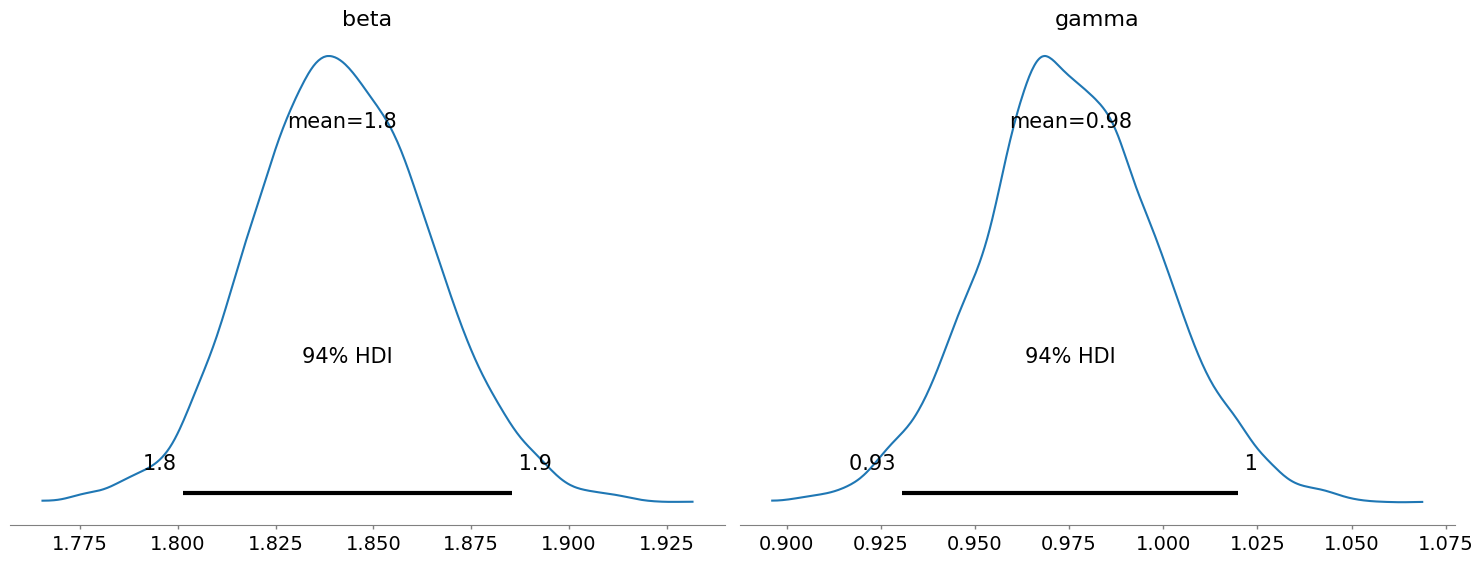

In [26]:
fig = arviz.plot_posterior(fit, var_names=('beta','gamma'), backend_kwargs={"constrained_layout":True})

In [27]:
#感染者数の事後分布
I_sim = fit['I_sim']
summary = np.zeros((Nt_sampled,3))
for j in range(Nt_sampled):
  I_sim_j = I_sim[j,:]
  mu = np.mean(I_sim_j)
  upp = np.quantile(I_sim_j, 0.975)
  low = np.quantile(I_sim_j, 0.025)
  summary[j,0] = mu
  summary[j,1] = upp
  summary[j,2] = low

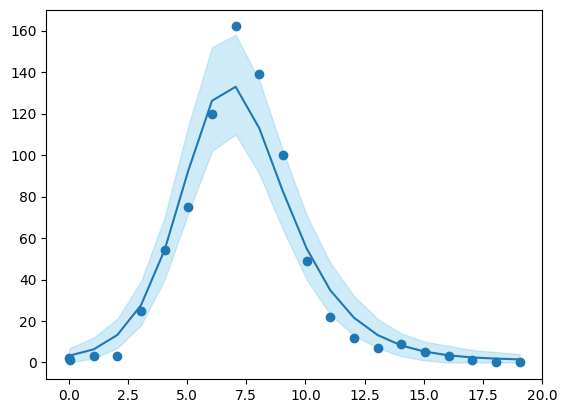

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, summary[:,0])
ax.fill_between(t, summary[:,2], summary[:,1], alpha=0.4, color='skyblue')
ax.scatter(t, I)
plt.show()